In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Data handling
!pip install numpy pandas

# Visualization
!pip install matplotlib seaborn tqdm

# PyTorch
!pip install torch torchvision torchaudio

# Pretrained embeddings (Gensim)
!pip install gensim

# Scikit-learn metrics and preprocessing
!pip install scikit-learn

# Transformers (Hugging Face)
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 176.9 MB/s  0:00:00


In [ ]:
# ----------------------------
# Standard libraries
# ----------------------------
import os
import time
import copy
import random
from pathlib import Path
from collections import Counter, defaultdict
import urllib.request

# ----------------------------
# Data handling
# ----------------------------
import numpy as np
import pandas as pd

# ----------------------------
# Visualization
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # optional progress bars

# ----------------------------
# PyTorch
# ----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.nn.utils.rnn import pad_sequence

# ----------------------------
# Transformers
# ----------------------------

from transformers import BertTokenizerFast, BertForTokenClassification


# ----------------------------
# Scikit-learn metrics and preprocessing
# ----------------------------
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score,
    classification_report , f1_score
)
from sklearn.preprocessing import label_binarize


Data Downloading

In [ ]:
base_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/r2.14/"
files = [
    "en_ewt-ud-train.conllu",
    "en_ewt-ud-dev.conllu",
    "en_ewt-ud-test.conllu"
]
for f in files:
    url = base_url + f
    print("Downloading", url)
    urllib.request.urlretrieve(url, f)



for root, dirs, files in os.walk(".", topdown=True):
    for name in files:
        if name.endswith(".conllu"):
            print(os.path.join(root, name))




./en_ewt-ud-test.conllu
./en_ewt-ud-train.conllu
./en_ewt-ud-dev.conllu


Data Reading

In [ ]:
def read_conllu(path):
    sentences = []
    words, tags = [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(list(zip(words, tags)))
                    words, tags = [], []
                continue
            if line.startswith("#"):
                continue
            cols = line.split("\t")
            if "-" in cols[0] or "." in cols[0]:
                continue
            word = cols[1]
            upos = cols[3]
            words.append(word)
            tags.append(upos)
    if words:
        sentences.append(list(zip(words, tags)))
    return sentences


Datasets

In [ ]:
train_sents = read_conllu("./en_ewt-ud-train.conllu")
dev_sents   = read_conllu("./en_ewt-ud-dev.conllu")
test_sents  = read_conllu("./en_ewt-ud-test.conllu")

#Dataset sizes
len(train_sents), len(dev_sents), len(test_sents)

(12544, 2001, 2077)

Data Pre-Processing

In [ ]:
all_tags = [tag for sent in train_sents for (_, tag) in sent]
tag2id = {t: i for i, t in enumerate(sorted(set(all_tags)))}
id2tag = {i: t for t, i in tag2id.items()}
num_tags = len(tag2id)
all_words = [w.lower() for sent in train_sents for (w, _) in sent]
word_counts = Counter(all_words)
word2id = {"<pad>": 0, "<unk>": 1}
for w, c in word_counts.items():
    word2id[w] = len(word2id)
id2word = {i: w for w, i in word2id.items()}
vocab_size = len(word2id)
print("Vocab size:", vocab_size)
print("Num tags:", num_tags)
print(tag2id)
print(id2tag)

Vocab size: 16656
Num tags: 17
{'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CCONJ': 4, 'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9, 'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'SCONJ': 13, 'SYM': 14, 'VERB': 15, 'X': 16}
{0: 'ADJ', 1: 'ADP', 2: 'ADV', 3: 'AUX', 4: 'CCONJ', 5: 'DET', 6: 'INTJ', 7: 'NOUN', 8: 'NUM', 9: 'PART', 10: 'PRON', 11: 'PROPN', 12: 'PUNCT', 13: 'SCONJ', 14: 'SYM', 15: 'VERB', 16: 'X'}


Baseline Model

In [ ]:
word_tag_counts = defaultdict(Counter)
global_tag_counts = Counter()

for sent in train_sents:
    for w, t in sent:
        w = w.lower()
        word_tag_counts[w][t] += 1
        global_tag_counts[t]  += 1

most_common_tag = global_tag_counts.most_common(1)[0][0]

def baseline_tag(word):
    w = word.lower()
    if w in word_tag_counts:
        return word_tag_counts[w].most_common(1)[0][0]
    else:
        return most_common_tag
def eval_baseline(sentences, tag2id):
    y_true, y_pred = [], []
    for sent in sentences:
        for w, t in sent:
            y_true.append(tag2id[t])
            y_pred.append(tag2id[baseline_tag(w)])
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

from sklearn.metrics import classification_report, precision_recall_fscore_support, average_precision_score

def evaluate_baseline_classifier(sentences, tag2id, id2tag):
    y_true, y_pred = eval_baseline(sentences, tag2id)
    tag_names = [id2tag[i] for i in range(len(id2tag))]

    print("Classification report")
    print(classification_report(y_true, y_pred, target_names=tag_names, zero_division=0))

    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    print(f"Macro Precision: {macro_p:.4f}")
    print(f"Macro Recall:    {macro_r:.4f}")
    print(f"Macro F1:        {macro_f1:.4f}")

    num_tags = len(id2tag)
    pr_aucs = []
    probs_dummy = np.zeros((len(y_true), num_tags))
    for i in range(len(y_pred)):
        probs_dummy[i, y_pred[i]] = 1.0

    for c in range(num_tags):
        y_bin = (y_true == c).astype(int)
        pr_auc_c = average_precision_score(y_bin, probs_dummy[:, c])
        pr_aucs.append(pr_auc_c)

    print("\nPer-tag PR-AUC:")
    for i, auc in enumerate(pr_aucs):
        print(f"{id2tag[i]:>6}: {auc:.4f}")
    print(f"\nMacro PR-AUC: {np.mean(pr_aucs):.4f}")

    return {
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "per_tag_pr_auc": pr_aucs,
        "macro_pr_auc": float(np.mean(pr_aucs)),
    }

print("Baseline -> Train ")
baseline_train_metrics = evaluate_baseline_classifier(train_sents, tag2id, id2tag)
print("\nBaseline -> Dev ")
baseline_dev_metrics = evaluate_baseline_classifier(dev_sents, tag2id, id2tag)
print("\nBaseline -> Test ")
baseline_test_metrics = evaluate_baseline_classifier(test_sents, tag2id, id2tag)



Baseline -> Train 
Classification report
              precision    recall  f1-score   support

         ADJ       0.91      0.93      0.92     13155
         ADP       0.86      0.88      0.87     17791
         ADV       0.92      0.80      0.85     10104
         AUX       0.92      0.90      0.91     12814
       CCONJ       0.98      1.00      0.99      6688
         DET       0.96      0.98      0.97     16300
        INTJ       0.96      0.76      0.85       695
        NOUN       0.92      0.94      0.93     34803
         NUM       0.95      1.00      0.97      4127
        PART       0.71      0.99      0.83      5748
        PRON       0.97      0.92      0.95     18661
       PROPN       0.95      0.86      0.90     12620
       PUNCT       0.99      1.00      0.99     23597
       SCONJ       0.65      0.62      0.63      3822
         SYM       0.89      0.82      0.86       721
        VERB       0.91      0.89      0.90     22577
           X       0.79      0.51      0

Data-Loaders for BERT Model

In [ ]:
MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

class BERT_POS_Dataset(Dataset):
    def __init__(self, sentences, tag2id, tokenizer, max_len=128):
        self.sentences = sentences
        self.tag2id = tag2id
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = [w for (w, t) in self.sentences[idx]]
        tags = [t for (w, t) in self.sentences[idx]]
        encoding = self.tokenizer(
            words,
            is_split_into_words=True,
            return_offsets_mapping=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        labels = []
        word_ids = encoding.word_ids(batch_index=0)
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(self.tag2id[tags[word_idx]])
            else:
                labels.append(-100)
            previous_word_idx = word_idx

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels)
        item.pop('offset_mapping')

        return item

# Initialize Datasets
train_dataset = BERT_POS_Dataset(train_sents, tag2id, tokenizer)
dev_dataset = BERT_POS_Dataset(dev_sents, tag2id, tokenizer)
test_dataset = BERT_POS_Dataset

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 BERT Model-Setup

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)
model.to(device)

# Hyperparameters for Fine-Tuning
optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hyper-parameter Grid

In [ ]:
param_grid = {
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [2, 3, 4],
    'weight_decay': [0.0, 0.01]
}


Train on GPU

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Mac MPS (Metal Performance Shaders) acceleration")
else:
    device = torch.device("cpu")
    print("No GPU found. Using CPU!")

Using GPU: Tesla T4


Model Optimization  with Random Search

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizerFast, BertForTokenClassification

if not torch.cuda.is_available():
    raise SystemError("GPU not found! Change Runtime settings to T4 GPU.")
device = torch.device("cuda")
print(f"Using GPU: {torch.cuda.get_device_name(0)}")
print("Pre-tokenizing data (this takes 10 seconds)...")

def pre_tokenize_dataset(sentences, tokenizer, tag2id, max_len=128):
    # Separate words and tags
    all_words = [[w for (w, t) in sent] for sent in sentences]
    all_tags  = [[t for (w, t) in sent] for sent in sentences]

    # Batch encode everything at once
    encodings = tokenizer(
        all_words,
        is_split_into_words=True,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    labels = []
    for i, sent_tags in enumerate(all_tags):
        word_ids = encodings.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(tag2id[sent_tags[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    # Create a TensorDataset (Very fast for DataLoaders)
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

train_tensor_dataset = pre_tokenize_dataset(train_sents, tokenizer, tag2id)
dev_tensor_dataset   = pre_tokenize_dataset(dev_sents, tokenizer, tag2id)
param_grid = {
    'learning_rate': [3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [2, 3],
    'weight_decay': [0.01]
}

def calculate_f1(preds, labels):
    preds_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    valid_indices = labels_flat != -100
    return f1_score(labels_flat[valid_indices], preds_flat[valid_indices], average='macro')

def sample_random_config(grid):
    return {k: random.choice(v) for k, v in grid.items()}

os.makedirs("bert_random_search_checkpoints", exist_ok=True)
NUM_TRIALS = 2

print(f"\n🚀 Starting Fast Training for {NUM_TRIALS} trials...")

for trial in range(NUM_TRIALS):
    config = sample_random_config(param_grid)
    print(f"\n--- Trial {trial+1} Config: {config} ---")

    train_loader = DataLoader(train_tensor_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    dev_loader   = DataLoader(dev_tensor_dataset, batch_size=config['batch_size'], num_workers=2)

    model = BertForTokenClassification.from_pretrained(
        MODEL_NAME, num_labels=len(tag2id), id2label=id2tag, label2id=tag2id
    )
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    min_val_loss = float('inf')
    save_path = f"bert_random_search_checkpoints/trial_{trial+1}_best.pt"

    for epoch in range(config['epochs']):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Ep {epoch+1}"):
            b_ids, b_mask, b_labels = [b.to(device) for b in batch]

            model.zero_grad()
            outputs = model(b_ids, attention_mask=b_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in dev_loader:
                b_ids, b_mask, b_labels = [b.to(device) for b in batch]
                outputs = model(b_ids, attention_mask=b_mask, labels=b_labels)
                val_loss += outputs.loss.item()

                all_preds.append(outputs.logits.detach().cpu().numpy())
                all_labels.append(b_labels.cpu().numpy())

        avg_val_loss = val_loss / len(dev_loader)
        val_f1 = calculate_f1(np.concatenate(all_preds), np.concatenate(all_labels))
        print(f"  -> Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

Using GPU: Tesla T4
Pre-tokenizing data (this takes 10 seconds)...

🚀 Starting Fast Training for 2 trials...

--- Trial 1 Config: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 2, 'weight_decay': 0.01} ---


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Ep 1: 100%|██████████| 784/784 [04:18<00:00,  3.03it/s]


  -> Val Loss: 0.1007 | Val F1: 0.9236


Ep 2: 100%|██████████| 784/784 [04:21<00:00,  3.00it/s]


  -> Val Loss: 0.1037 | Val F1: 0.9422

--- Trial 2 Config: {'learning_rate': 3e-05, 'batch_size': 32, 'epochs': 3, 'weight_decay': 0.01} ---


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Ep 1: 100%|██████████| 392/392 [03:55<00:00,  1.67it/s]


  -> Val Loss: 0.1086 | Val F1: 0.9126


Ep 2: 100%|██████████| 392/392 [03:55<00:00,  1.67it/s]


  -> Val Loss: 0.0963 | Val F1: 0.9376


Ep 3: 100%|██████████| 392/392 [03:55<00:00,  1.67it/s]


  -> Val Loss: 0.1095 | Val F1: 0.9400


Metrics

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import label_binarize
from collections import defaultdict

# We need to pre-tokenize the test set just like we did for train/dev
print("Pre-tokenizing Test Set...")
test_tensor_dataset = pre_tokenize_dataset(test_sents, tokenizer, tag2id)
test_loader = DataLoader(test_tensor_dataset, batch_size=32, num_workers=2)

# Load the state dict
checkpoint = torch.load("bert_random_search_checkpoints/trial_1_best.pt")

# Recreate the model architecture
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(tag2id), id2label=id2tag, label2id=tag2id
)

# Load weights
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

print("Loaded best model from Trial 1")

def compute_metrics(y_true, y_pred, y_score, num_classes):
    """
    y_true: [N] gold class ids
    y_pred: [N] predicted class ids
    y_score: [N, C] probabilities for each class
    """
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(num_classes)), average=None, zero_division=0
    )

    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    pr_auc_per_class = []
    for c in range(num_classes):
        y_true_bin = (y_true == c).astype(int)          # one-vs-rest
        if y_true_bin.sum() == 0:
            pr_auc_per_class.append(np.nan)             # tag not present in this split
        else:
            pr_auc_per_class.append(
                average_precision_score(y_true_bin, y_score[:, c])  # <-- use probs!
            )

    macro_pr_auc = np.nanmean(pr_auc_per_class)

    return {
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "support_per_class": support,
        "pr_auc_per_class": pr_auc_per_class,   # <-- NEW/REAL per tag
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "macro_pr_auc": macro_pr_auc,
    }

import numpy as np
import torch

def evaluate_bert(model, loader, num_classes):
    model.eval()
    total_loss = 0
    y_true_masked, y_pred_masked = [], []
    y_score_masked = []   # <-- NEW: store probs per token
    IGNORE_INDEX = -100

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
            else:
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits  # [B, L, C]
            total_loss += loss.item()

            probs = torch.softmax(logits, dim=-1)  # <-- NEW

            logits_flat = logits.view(-1, num_classes)
            probs_flat  = probs.view(-1, num_classes)     # <-- NEW
            labels_flat = b_labels.view(-1)
            preds_flat  = logits_flat.argmax(dim=1)

            mask = (labels_flat != IGNORE_INDEX)

            y_true_masked.extend(labels_flat[mask].cpu().numpy())
            y_pred_masked.extend(preds_flat[mask].cpu().numpy())
            y_score_masked.append(probs_flat[mask].cpu().numpy())  # <-- NEW

    y_score_masked = np.vstack(y_score_masked)  # shape [N_masked, C]

    metrics = compute_metrics(y_true_masked, y_pred_masked, y_score_masked, num_classes)
    metrics["loss"] = total_loss / len(loader)

    return metrics


def print_evaluation_report(metrics, title, id2tag):
    print(f"\n{'='*20} {title} {'='*20}")
    print(f"{'TAG':<12} {'PREC':>8} {'REC':>8} {'F1':>8} {'PR-AUC':>10} {'SUPPORT':>10}")
    print("-" * 70)

    for i in range(len(metrics['precision_per_class'])):
        tag_name = id2tag.get(i, f"Tag_{i}")
        p = metrics['precision_per_class'][i]
        r = metrics['recall_per_class'][i]
        f = metrics['f1_per_class'][i]
        s = metrics['support_per_class'][i]
        auc = metrics['pr_auc_per_class'][i]

        if s > 0:
            auc_str = f"{auc:.4f}" if not (auc is None or np.isnan(auc)) else "NA"
            print(f"{tag_name:<12} {p:>8.2f} {r:>8.2f} {f:>8.2f} {auc_str:>10} {int(s):>10}")

    print("-" * 70)
    print(f"Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"Macro Recall   : {metrics['macro_recall']:.4f}")
    print(f"Macro F1       : {metrics['macro_f1']:.4f}")
    print(f"Macro PR-AUC   : {metrics['macro_pr_auc']:.4f}")
    print(f"Model Loss     : {metrics['loss']:.4f}")


def run_full_evaluation(model, train_loader, dev_loader, test_loader, num_tags, id2tag):

    # Train Set
    print("Evaluating Train Set...")
    train_metrics = evaluate_bert(model, train_loader, num_tags)
    print_evaluation_report(train_metrics, "My BERT Model -> Train", id2tag)

    # Dev Set
    print("Evaluating Dev Set...")
    dev_metrics = evaluate_bert(model, dev_loader, num_tags)
    print_evaluation_report(dev_metrics, "My BERT Model -> Dev", id2tag)

    # Test Set
    print("Evaluating Test Set...")
    test_metrics = evaluate_bert(model, test_loader, num_tags)
    print_evaluation_report(test_metrics, "My BERT Model -> Test", id2tag)

run_full_evaluation(model, train_loader, dev_loader, test_loader, len(tag2id), id2tag)

Pre-tokenizing Test Set...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded best model from Trial 1
Evaluating Train Set...

==================== My BERT Model -> Train ====================
TAG              PREC      REC       F1     PR-AUC    SUPPORT
----------------------------------------------------------------------
ADJ              0.98     0.97     0.98     0.9966      13150
ADP              0.99     0.99     0.99     0.9992      17783
ADV              0.97     0.98     0.98     0.9962      10091
AUX              1.00     1.00     1.00     0.9998      12806
CCONJ            1.00     1.00     1.00     0.9998       6683
DET              1.00     1.00     1.00     0.9998      16295
INTJ             0.99     0.91     0.95     0.9869        695
NOUN             0.98     0.99     0.98     0.9987      34782
NUM              0.99     0.99     0.99     0.9998       4127
PART             1.00     1.00     1.00     1.0000       5746
PRON             1.00     1.00     1.00     0.9998      18643
PROPN            0.98     0.97     0.97     0.9960      12616
PU

Learning Curves

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Plots the Loss and F1-Score curves for training and validation.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)

    best_loss_epoch = np.argmin(history['val_loss'])
    best_val_loss = history['val_loss'][best_loss_epoch]
    plt.plot(best_loss_epoch + 1, best_val_loss, 'r*', markersize=15, label=f'Best Val Loss: {best_val_loss:.4f}')

    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    if 'train_f1' in history and len(history['train_f1']) > 0:
        plt.plot(epochs, history['train_f1'], 'b-o', label='Train Macro F1', linewidth=2)

    plt.plot(epochs, history['val_f1'], 'g-o', label='Validation Macro F1', linewidth=2)

    plt.title('Training and Validation Macro F1', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')

    # Highlight best validation F1
    best_f1_epoch = np.argmax(history['val_f1'])
    best_val_f1 = history['val_f1'][best_f1_epoch]
    plt.plot(best_f1_epoch + 1, best_val_f1, 'r*', markersize=15, label=f'Best Val F1: {best_val_f1:.4f}')

    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

:Config: {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 3, 'weight_decay': 0.01} ---

Retraining with Best Config to generate plots: {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 3, 'weight_decay': 0.01}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3:   0%|          | 0/392 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

  Result Ep 1: Train Loss 0.2226 | Val F1 0.9138


Epoch 2/3:   0%|          | 0/392 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

  Result Ep 2: Train Loss 0.0487 | Val F1 0.9416


Epoch 3/3:   0%|          | 0/392 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]

  Result Ep 3: Train Loss 0.0240 | Val F1 0.9332

Generating Learning Curves...


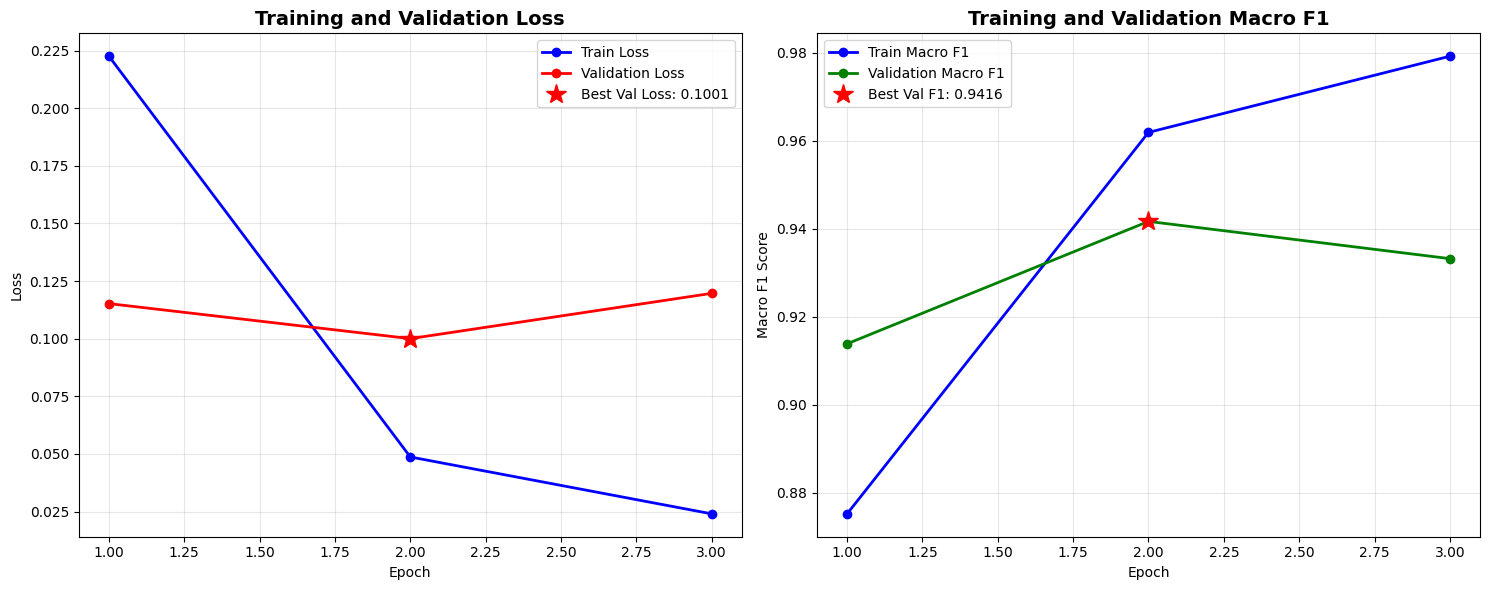

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

best_global_config = {'learning_rate': 5e-5, 'batch_size': 32, 'epochs': 3, 'weight_decay': 0.01}

print(f"Retraining with Best Config to generate plots: {best_global_config}")

# Re-init DataLoaders
train_loader = DataLoader(train_tensor_dataset, batch_size=best_global_config['batch_size'], shuffle=True, num_workers=2)
dev_loader   = DataLoader(dev_tensor_dataset, batch_size=best_global_config['batch_size'], num_workers=2)

# Re-init Model
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(tag2id), id2label=id2tag, label2id=tag2id
)
model.to(device)
optimizer = AdamW(model.parameters(), lr=best_global_config['learning_rate'], weight_decay=best_global_config['weight_decay'])

history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [],   'val_f1': []
}

# Training Loop
for epoch in range(best_global_config['epochs']):

    model.train()
    total_train_loss = 0
    all_train_preds, all_train_labels = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{best_global_config['epochs']}", leave=True)

    for batch in pbar:
        b_ids, b_mask, b_labels = [b.to(device) for b in batch]

        model.zero_grad()
        outputs = model(b_ids, attention_mask=b_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_train_loss += loss.item()

        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        all_train_preds.append(outputs.logits.detach().cpu().numpy())
        all_train_labels.append(b_labels.cpu().numpy())

    # Train Metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_f1 = calculate_f1(np.concatenate(all_train_preds), np.concatenate(all_train_labels))

    model.eval()
    total_val_loss = 0
    all_val_preds, all_val_labels = [], []

    # Optional: Add a small bar for validation too
    for batch in tqdm(dev_loader, desc="Validating", leave=False):
        with torch.no_grad():
            b_ids, b_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_ids, attention_mask=b_mask, labels=b_labels)
            total_val_loss += outputs.loss.item()

            all_val_preds.append(outputs.logits.detach().cpu().numpy())
            all_val_labels.append(b_labels.cpu().numpy())

    # Val Metrics
    avg_val_loss = total_val_loss / len(dev_loader)
    val_f1 = calculate_f1(np.concatenate(all_val_preds), np.concatenate(all_val_labels))

    # Store in history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    # Print summary at the end of the epoch
    print(f"  Result Ep {epoch+1}: Train Loss {avg_train_loss:.4f} | Val F1 {val_f1:.4f}")

# --- 3. Generate Plot ---
print("\nGenerating Learning Curves...")
plot_training_history(history)

# **Prompting**(bonus)

In [ ]:
import random, json
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

def extract_tokens_tags(example):
    """
    Tries to extract (tokens, gold_tags) from one test example.
    Supports common formats:
      A) [(token, tag), (token, tag), ...]
      B) {"tokens":[...], "tags":[...]} or {"tokens":[...], "pos_tags":[...]} etc.
      C) {"words":[...], "labels":[...]} etc.
    """
    # Case A: list/tuple of (token, tag)
    if isinstance(example, (list, tuple)) and len(example) > 0 and isinstance(example[0], (list, tuple)) and len(example[0]) == 2:
        tokens = [w for w, t in example]
        tags = [t for w, t in example]
        return tokens, tags

    # Case B: dict with common keys
    if isinstance(example, dict):
        token_keys = ["tokens", "words", "sentence", "x"]
        tag_keys   = ["tags", "pos_tags", "labels", "y"]

        tokens = None
        tags = None

        for k in token_keys:
            if k in example:
                tokens = example[k]
                break

        for k in tag_keys:
            if k in example:
                tags = example[k]
                break

        if tokens is not None and tags is not None:
            return list(tokens), list(tags)

    raise ValueError(
        "Can't extract tokens/tags from test_sents element. "
        "Print test_sents[0] and adjust extract_tokens_tags accordingly."
    )

def build_prompt(tokens, tagset, demos=None):
    demos_txt = ""
    if demos:
        for ex_toks, ex_tags in demos:
            demos_txt += (
                f"Example\nTokens: {json.dumps(ex_toks)}\n"
                f"Output: {json.dumps({'tags': ex_tags})}\n\n"
            )

    return f"""{demos_txt}You are a POS tagger.

Rules:
- Use ONLY tags from this tagset: {sorted(list(tagset))}
- Output MUST be valid JSON only (no extra text).
- Output format: {{"tags": ["TAG1","TAG2",...]}}
- The number of tags must equal the number of tokens exactly.

Tokens:
{json.dumps(tokens)}
"""

def parse_llm_output(text, expected_len):
    obj = json.loads(text)
    tags = obj["tags"]
    if len(tags) != expected_len:
        raise ValueError(f"Expected {expected_len} tags, got {len(tags)}")
    return tags

def macro_f1_from_tag_seqs(gold_seqs, pred_seqs, tag2id):
    y_true, y_pred = [], []
    for gold, pred in zip(gold_seqs, pred_seqs):
        for g, p in zip(gold, pred):
            y_true.append(tag2id[g])
            y_pred.append(tag2id.get(p, -1))  # unknown tags count as wrong

    labels = list(tag2id.values())
    _, _, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="macro", zero_division=0
    )
    return float(macro_f1)


In [ ]:
K = 10
idxs = random.sample(range(len(test_sents)), K)

subset_tokens = []
subset_gold = []

for i in idxs:
    toks, gold = extract_tokens_tags(test_sents[i])
    subset_tokens.append(toks)
    subset_gold.append(gold)

demos = None
# demos = [
#     (["The","dog","runs","."], ["DET","NOUN","VERB","."]),
# ]

TAGSET = set(tag2id.keys())
prompts = [build_prompt(toks, TAGSET, demos=demos) for toks in subset_tokens]

for i in range(K):
    print(f"\n{'='*20} PROMPT #{i+1} (test idx={idxs[i]}) {'='*20}\n")
    print(prompts[i])

    print("\n---- GOLD ----")
    print(list(zip(subset_tokens[i], subset_gold[i])))
    print("lengths:", len(subset_tokens[i]), len(subset_gold[i]))





==================== PROMPT #1 (test idx=791) ====================

You are a POS tagger.

Rules:
- Use ONLY tags from this tagset: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
- Output MUST be valid JSON only (no extra text).
- Output format: {"tags": ["TAG1","TAG2",...]}
- The number of tags must equal the number of tokens exactly.

Tokens:
["could", "you", "also", "CC", "me", "the", "first", "few", "times", "you", "send", "it", "?"]


---- GOLD ----
[('could', 'AUX'), ('you', 'PRON'), ('also', 'ADV'), ('CC', 'VERB'), ('me', 'PRON'), ('the', 'DET'), ('first', 'ADJ'), ('few', 'ADJ'), ('times', 'NOUN'), ('you', 'PRON'), ('send', 'VERB'), ('it', 'PRON'), ('?', 'PUNCT')]
lengths: 13 13

==================== PROMPT #2 (test idx=683) ====================

You are a POS tagger.

Rules:
- Use ONLY tags from this tagset: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PR

In [ ]:
llm_outputs = [
    # PROMPT #1 (13 tokens)
    '{"tags":["AUX","PRON","ADV","VERB","PRON","DET","ADJ","ADJ","NOUN","PRON","VERB","PRON","PUNCT"]}',

    # PROMPT #2 (3 tokens)
    '{"tags":["DET","NOUN","PUNCT"]}',

    # PROMPT #3 (3 tokens)
    '{"tags":["PART","ADJ","PUNCT"]}',

    # PROMPT #4 (16 tokens)
    '{"tags":["INTJ","ADV","VERB","NOUN","SCONJ","PRON","VERB","ADJ","CCONJ","VERB","PRON","ADP","DET","NOUN","VERB","PUNCT"]}',

    # PROMPT #5 (1 token)
    '{"tags":["PROPN"]}',

    # PROMPT #6 (8 tokens)
    '{"tags":["NOUN","ADP","ADJ","PROPN","NOUN","ADP","PROPN","PUNCT"]}',

    # PROMPT #7 (15 tokens)
    '{"tags":["DET","NOUN","ADP","PROPN","PROPN","PROPN","AUX","ADV","ADJ","CCONJ","ADJ","PART","VERB","ADP","PUNCT"]}',

    # PROMPT #8 (7 tokens)
    '{"tags":["PROPN","PROPN","PUNCT","NUM","PUNCT","PROPN","PROPN"]}',

    # PROMPT #9 (9 tokens)
    '{"tags":["ADV","ADJ","NOUN","ADP","DET","NOUN","ADP","PROPN","PUNCT"]}',

    # PROMPT #10 (6 tokens)
    '{"tags":["PROPN","PROPN","PUNCT","PROPN","PROPN","PUNCT"]}',
]

assert len(llm_outputs) == K, f"Expected {K} LLM outputs, got {len(llm_outputs)}"


In [ ]:
pred_seqs = [parse_llm_output(out, len(toks)) for out, toks in zip(llm_outputs, subset_tokens)]

# flatten gold/pred to ids
y_true = []
y_pred = []
for gold_sent, pred_sent in zip(subset_gold, pred_seqs):
    for g, p in zip(gold_sent, pred_sent):
        y_true.append(tag2id[g])
        y_pred.append(tag2id.get(p, -1))

present_labels = sorted(set(y_true))  # only labels that appear in these 10 sentences

_, _, llm_macro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=present_labels, average="macro", zero_division=0
)

print("LLM Macro F1 on 10-test subset (labels present only):", llm_macro_f1)
print("Token accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))


# Optional: show per-sentence accuracy just for inspection
def sent_token_accuracy(gold, pred):
    return sum(g == p for g, p in zip(gold, pred)) / len(gold)

rows = []
for j in range(K):
    rows.append({
        "idx_in_test": idxs[j],
        "num_tokens": len(subset_tokens[j]),
        "token_acc": sent_token_accuracy(subset_gold[j], pred_seqs[j]),
        "sentence_preview": " ".join(subset_tokens[j][:12]) + (" ..." if len(subset_tokens[j]) > 12 else "")
    })

df_llm = pd.DataFrame(rows).sort_values("token_acc", ascending=False)
display(df_llm)


LLM Macro F1 on 10-test subset (labels present only): 1.0
Token accuracy: 1.0


,idx_in_test,num_tokens,token_acc,sentence_preview
0,791,13,1.0,could you also CC me the first few times you s...
1,683,3,1.0,A reminder .
2,1729,3,1.0,Not impressed .
3,733,16,1.0,Please confidentially share matters as you thi...
4,726,1,1.0,Vince
5,1472,8,1.0,Name of specific Hibachi restaurant in Chicago ?
6,1970,15,1.0,The people at Gulf Coast Siding were very easy...
7,133,7,1.0,"Tanvir Hussain , 24 , London E10"
8,1386,9,1.0,how many ounces in a pint in ireland ?
9,1147,6,1.0,"Atal Pharmacy , Karol Bag ."


# Dataset Statistics

In [ ]:
def corpus_stats(sentences):
    lengths = [len(s) for s in sentences]
    num_sents = len(sentences)
    num_tokens = sum(lengths)
    avg_len = np.mean(lengths)
    max_len = np.max(lengths)
    min_len = np.min(lengths)
    return {
        "num_sentences": num_sents,
        "num_tokens": num_tokens,
        "avg_sentence_length": avg_len,
        "min_sentence_length": min_len,
        "max_sentence_length": max_len,
        "sentence_lengths": lengths
    }
train_stats = corpus_stats(train_sents)
dev_stats = corpus_stats(dev_sents)
test_stats = corpus_stats(test_sents)



In [ ]:
import pandas as pd

df_stats = pd.DataFrame([
    {"Split": "Train", **train_stats},
    {"Split": "Dev",   **dev_stats},
    {"Split": "Test",  **test_stats},
])
df_stats = df_stats.drop(columns=["sentence_lengths"])
df_stats

,Split,num_sentences,num_tokens,avg_sentence_length,min_sentence_length,max_sentence_length
0,Train,12544,204578,16.308833,1,159
1,Dev,2001,25149,12.568216,1,75
2,Test,2077,25094,12.081849,1,81


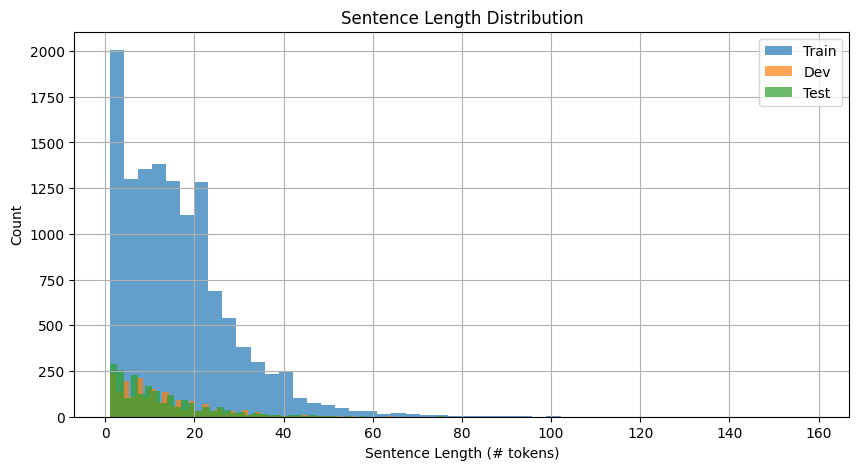

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(train_stats["sentence_lengths"], bins=50, alpha=0.7, label="Train")
plt.hist(dev_stats["sentence_lengths"],   bins=50, alpha=0.7, label="Dev")
plt.hist(test_stats["sentence_lengths"],  bins=50, alpha=0.7, label="Test")
plt.xlabel("Sentence Length (# tokens)")
plt.ylabel("Count")
plt.title("Sentence Length Distribution")
plt.legend()
plt.grid(True)
plt.show()

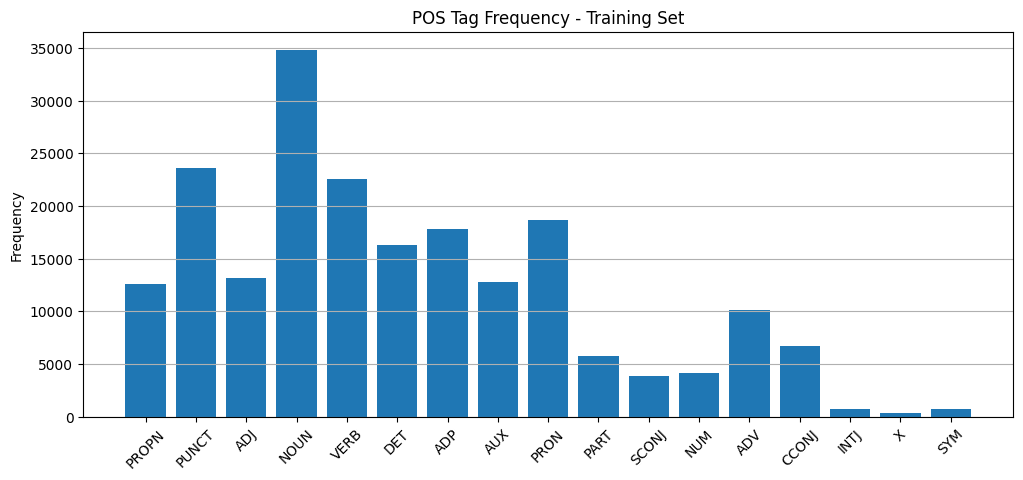

In [ ]:
tag_counts = Counter(tag for sent in train_sents for (_, tag) in sent)
tags = list(tag_counts.keys())
freqs = [tag_counts[t] for t in tags]
plt.figure(figsize=(12,5))
plt.bar(tags, freqs)
plt.title("POS Tag Frequency - Training Set")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()